In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tensorflow-addons
!pip install toolz scikit-allel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 11.1 MB/s eta 0:00:00


In [ ]:
import numpy as np
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Tensorflow version 2.12.0


## Setup

In [ ]:
import os
# os.environ["MODIN_CPUS"] = "8"
# from distributed import Client
# client = Client()
import numpy as np
import math
import re
import itertools
import random
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow_addons as tfa
from sklearn import metrics
from sklearn.model_selection import KFold
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import constraints
from tensorflow.keras import initializers
from tensorflow.keras import regularizers
from tensorflow.keras.applications import efficientnet as efn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from tensorflow.keras.constraints import Constraint
# import allel
from scipy.spatial.distance import squareform
%matplotlib inline
from toolz import interleave
from tqdm import tqdm
import allel
from scipy.spatial.distance import squareform
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LassoCV, ElasticNetCV
from sklearn.model_selection import KFold,StratifiedKFold

print("Tensorflow version " + tf.__version__)

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Tensorflow version 2.12.0


## Hardware Config

In [ ]:
# Detect hardware, return appropriate distribution strategy
try:
    TPU = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', TPU.master())
except ValueError:
    print('Running on GPU')
    TPU = None

if TPU:
    tf.config.experimental_connect_to_cluster(TPU)
    tf.tpu.experimental.initialize_tpu_system(TPU)
    strategy = tf.distribute.TPUStrategy(TPU)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

N_REPLICAS = strategy.num_replicas_in_sync
# Number of computing cores, is 8 for a TPU V3-8
print(f'N_REPLICAS: {N_REPLICAS}')

Running on TPU  grpc://10.46.134.218:8470
N_REPLICAS: 8


## Prepare the data

In [ ]:
root_dir = '[data_path]'
new_data_header = ""
# get header
with open(root_dir + "DELL.chr22.genotypes.full.vcf", 'r') as f_in:
    # skip info
    for line_num in range(70):
        f_in.readline()

    new_data_header = f_in.readline()
# load data

# load genotype
genotypes = pd.read_csv(root_dir + "DELL.chr22.genotypes.full.vcf", comment='#', sep='\t', names=new_data_header.strip().split('\t'), header=None).iloc[:-1, 9:].T
headers = genotypes.columns[:]
genotypes

,0,1,2,3,4,5,6,7,8,9,...,562,563,564,565,566,567,568,569,570,571
HG00096,0|0,0|0,0|0,0|0,0|0,0|0,1|1,0|0,0|0,0|0,...,0|0,0|0,0|1,0|0,0|0,0|0,0|0,0|0,0|0,0|0
HG00097,0|0,0|0,0|0,0|0,0|0,0|0,1|0,0|0,0|0,0|0,...,0|0,0|0,0|1,0|0,0|0,0|0,0|0,0|0,0|0,0|0
HG00099,0|0,0|0,0|0,0|0,0|0,0|0,1|0,0|0,0|0,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
HG00100,0|0,0|0,0|0,0|0,0|0,0|0,1|0,0|0,0|0,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
HG00101,0|0,0|0,0|0,0|0,0|0,0|0,1|0,0|0,0|0,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NA21137,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
NA21141,0|0,0|0,0|0,0|0,0|0,0|0,1|0,0|0,0|0,0|0,...,0|0,0|0,1|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
NA21142,0|0,0|0,0|0,0|0,0|0,0|0,0|1,0|0,0|0,0|0,...,0|0,0|0,1|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
NA21143,0|0,0|0,0|0,0|0,0|0,0|0,1|0,0|0,0|0,0|0,...,0|0,0|0,0|1,0|0,0|0,0|0,0|0,0|0,0|0,0|0


In [ ]:
ped_file = '[data_path]/integrated_call_samples.20130502.ALL.ped'
pedigree = pd.read_csv(ped_file, sep='\t', index_col='Individual ID')

In [ ]:
pedigree.head()

,Family ID,Paternal ID,Maternal ID,Gender,Phenotype,Population,Relationship,Siblings,Second Order,Third Order,Children,Other Comments
Individual ID,,,,,,,,,,,,
HG00096,HG00096,0,0,1,0,GBR,unrel,0,0,0,0,0
HG00097,HG00097,0,0,2,0,GBR,unrel,0,0,0,0,0
HG00098,HG00098,0,0,1,0,GBR,unrel,0,0,0,0,0
HG00099,HG00099,0,0,2,0,GBR,unrel,0,0,0,0,0
HG00100,HG00100,0,0,2,0,GBR,unrel,0,0,0,0,0


In [ ]:
Y_train = pedigree.loc[genotypes.index]['Population']
Y_train.shape

(2504,)

In [ ]:
X = genotypes[genotypes.index.isin(Y_train.index)]
X.shape

(2504, 572)

In [ ]:
X = X.replace({
    '0|0': 0,
    '0|1': 1,
    '1|0': 2,
    '1|1': 3
})
X.shape

(2504, 572)

### LD


In [ ]:
r = allel.rogers_huff_r(X.T)
LD = squareform(r ** 2)
LD.shape

(572, 572)

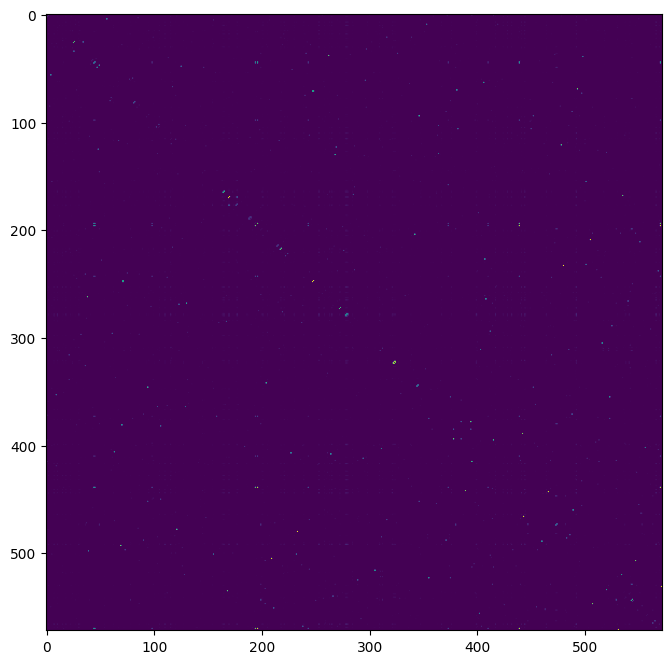

In [ ]:
plt.figure(figsize=(8,8))
plt.imshow(LD)

(array([421.,  44.,  29.,  31.,  47.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
 <BarContainer object of 5 artists>)

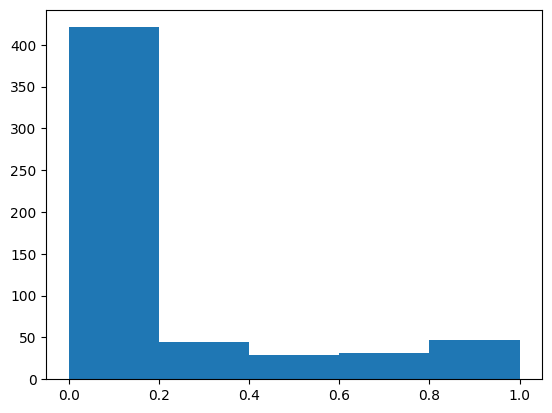

In [ ]:
bins = [0, 0.2, 0.4, 0.6, 0.8, 1]
plt.hist(np.amax(LD, axis=1), bins=bins)

In [ ]:
LD_max_freqs = np.amax(LD, axis=1)
bin_labels = np.digitize(LD_max_freqs, bins=bins, right=True)
bin_general_labels, bin_counts = np.unique(bin_labels, return_counts=True)
bin_general_labels, bin_counts

(array([1, 2, 3, 4, 5]), array([421,  44,  29,  31,  47]))

In [ ]:
# hyperparameters
feature_size = X.shape[1]
inChannel = 3
learning_rate = 0.004
weight_decay = 0.00001
embed_dim = 64  # Embedding size for each token
num_heads = 8 # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer
regularization_coef_l1 = 1e-4
dropout_rate = 0.25
chunk_size = feature_size
flanking_region_range = 0

## Convert to tensorflow dataset

In [ ]:
@tf.function()
def add_attention_mask(X_sample, y_sample):
  depth = 3
  # mask_size = tf.cast(X_sample.shape[0]*0.5, dtype=tf.int64)
  # mask_idx = tf.reshape(tf.random.shuffle(tf.range(X_sample.shape[0]))[:mask_size], (-1, 1))
  # updates = tf.math.add(tf.ones(shape=(mask_idx.shape[0]), dtype=tf.int64), 1)
  # X_masked = tf.tensor_scatter_nd_update(X_sample, mask_idx, updates)
  return tf.one_hot(X_sample, depth), tf.one_hot(y_sample, depth-1)

In [ ]:
def map_values_1(x):
  return 0 if (x == 0 or x == 1) else 1

def map_values_2(x):
  return 0 if (x == 0 or x == 2) else 1

def get_dataset(x, chunk_start, chunk_end, start_offset, end_offset, batch_size, training=True):
  AUTO = tf.data.AUTOTUNE

  _x = np.empty((x.shape[0] * 2, chunk_end-chunk_start), dtype=x.dtype)

  map_values_1_vec = np.vectorize(map_values_1)
  map_values_2_vec = np.vectorize(map_values_2)

  _x[0::2] = map_values_1_vec(x[:, chunk_start:chunk_end])
  _x[1::2] = map_values_2_vec(x[:, chunk_start:chunk_end])
  new_chunk_end = _x.shape[1]

  dataset = tf.data.Dataset.from_tensor_slices((_x,
                                                _x[:, start_offset:new_chunk_end-end_offset]))

  if training:
    dataset = dataset.shuffle(_x.shape[0], reshuffle_each_iteration=True)
    dataset = dataset.repeat()

  # Add Attention Mask
  dataset = dataset.map(add_attention_mask, num_parallel_calls=AUTO, deterministic=False)

  # Prefetech to not map the whole dataset
  dataset = dataset.prefetch(AUTO)

  dataset = dataset.batch(batch_size, drop_remainder=training, num_parallel_calls=AUTO)

  return dataset

## Custom Layers

In [ ]:
class SharedNet(tf.keras.Model):
    def __init__(self, conv1_n_filters, conv2_n_filters, conv1_kernel_size, conv2_kernel_size, fc_len, start_offset, end_offset, n_features_out):
        super(SharedNet, self).__init__()
        self.fc_len = fc_len
        self.start_offset = start_offset
        self.end_offset = end_offset
        self.n_features_out = n_features_out
        self.conv1 = layers.Conv1D(conv1_n_filters, kernel_size=conv1_kernel_size, strides=1, padding='same', activation=tf.nn.relu)
        self.pool1 = layers.MaxPooling1D(2)
        self.bn1 = layers.BatchNormalization()
        self.do1 = layers.Dropout(0.5)
        self.conv2 = layers.Conv1D(conv2_n_filters, kernel_size=conv2_kernel_size, strides=1, padding='same', activation=tf.nn.relu)
        self.pool2 = layers.MaxPooling1D(2)
        self.bn2 = layers.BatchNormalization()
        self.do2 = layers.Dropout(0.5)
        # self.flatten = layers.Flatten()
        self.fc1 = layers.Dense(4*(inChannel-1), activation=tf.nn.relu)
        self.reshape = layers.Reshape((-1, inChannel-1))
        # self.fc1 = layers.Dense(inChannel-1, activation=tf.nn.relu)

    def build(self, input_shape):
      self.input_len = input_shape[1]
      # self.reshape = layers.Reshape((self.input_len, self.fc_len))
      # super(SharedNet, self).build(input_shape)

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.pool2(x)
        # x = self.flatten(x)
        x = self.fc1(x)
        x = self.reshape(x)
        return x[:, self.start_offset:self.input_len-self.end_offset,]


class EachNet(tf.keras.Model):
    def __init__(self, num_classes):
        super(EachNet, self).__init__()
        self.fc1 = layers.Dense(num_classes, activation=tf.nn.softmax)
        self.dropout = tf.keras.layers.Dropout(0.5)

    def call(self, inputs):
        x = self.dropout(inputs)
        x = self.fc1(x)
        return x

## Modules

In [ ]:
def chunk_module(conv1_n_filters, conv2_n_filters,
                conv1_kernel_size, conv2_kernel_size,
                input_len, inChannel, fc_len=256,
                start_offset=0, end_offset=0):
  inputs = layers.Input(shape=(input_len, inChannel))
  n_features_out = input_len - start_offset - end_offset
  xa = SharedNet(conv1_n_filters, conv2_n_filters, conv1_kernel_size, conv2_kernel_size, fc_len, start_offset, end_offset, n_features_out)(inputs)
  xa_out1 = EachNet(inChannel-1)(xa)

  model = keras.Model(inputs=inputs, outputs=xa_out1)
  return model

In [ ]:
num_classes = len(np.unique(Y_train))
num_classes

26

## Model

In [ ]:
class DEEP_HLA(keras.Model):
  def __init__(
      self, in_channel,
      conv1_n_filters, conv2_n_filters,
      conv1_kernel_size, conv2_kernel_size,
      chunk_size=chunk_size,
      activation=tf.nn.relu,
      dropout_rate=0.5,
      flanking_region_range=flanking_region_range):
    super(DEEP_HLA, self).__init__()
    self.in_channel = in_channel
    self.embed_dim = embed_dim
    self.conv1_n_filters = conv1_n_filters
    self.conv2_n_filters = conv2_n_filters
    self.conv1_kernel_size = conv1_kernel_size
    self.conv2_kernel_size = conv2_kernel_size
    self.chunk_size = chunk_size
    self.activation = activation
    self.dropout_rate = dropout_rate
    self.flanking_region_range = flanking_region_range

  def build(self, input_shape):
    self.chunk_starts = list(range(0, input_shape[1], self.chunk_size))
    self.chunk_ends = []
    for cs in self.chunk_starts:
      self.chunk_ends.append(min(cs+self.chunk_size, input_shape[1]))
    self.mask_starts = [max(0, cs-self.flanking_region_range) for cs in self.chunk_starts]
    self.mask_ends = [min(ce+self.flanking_region_range, input_shape[1]) for ce in self.chunk_ends]
    self.chunkers = [chunk_module(self.conv1_n_filters, self.conv2_n_filters,
                                  self.conv1_kernel_size, self.conv2_kernel_size,
                                  self.mask_ends[i] - self.mask_starts[i],
                                  self.in_channel,
                                  start_offset=cs - self.mask_starts[i],
                                  end_offset=self.mask_ends[i]-self.chunk_ends[i]) for i,cs in enumerate(self.chunk_starts)]
    self.concat_layer = layers.Concatenate(axis=-2)
    super(DEEP_HLA, self).build(input_shape)


  def call(self, inputs):
    chunks = [self.chunkers[i](inputs[:, self.mask_starts[i]:self.mask_ends[i]]) for i, chunker in enumerate(self.chunkers)]
    y = self.concat_layer(chunks)
    return y


In [ ]:
METRIC = "val_loss"

def create_callbacks(kfold=0, metric = METRIC):

    reducelr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor= metric,
        mode='auto',
        factor=0.2,
        patience=3,
        verbose=0
    )

    earlystop = tf.keras.callbacks.EarlyStopping(
        monitor= metric,
        mode='auto',
        patience= 20,
        verbose=1,
        restore_best_weights=True
    )

    callbacks = [
                 reducelr,
                 earlystop]

    return callbacks

In [ ]:
def create_model(base_dim = 128):
  model =  DEEP_HLA(in_channel=inChannel,
      conv1_n_filters=base_dim, conv2_n_filters=base_dim//2,
      conv1_kernel_size=base_dim//2, conv2_kernel_size=base_dim//2)
  optimizer = tfa.optimizers.LAMB(learning_rate=learning_rate)
  model.compile(optimizer, loss='categorical_crossentropy', metrics=tf.keras.metrics.CategoricalAccuracy())
  return model

In [ ]:
temp_model = create_model()
temp_model.build((1, X.shape[1], inChannel))
temp_model.summary()

Model: "deep_hla_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 572, 2)            550350    
                                                                 
 concatenate (Concatenate)   multiple                  0         
                                                                 
Total params: 550,350
Trainable params: 549,966
Non-trainable params: 384
_________________________________________________________________


In [ ]:
def get_three_sets(x, y, random_state, population_label, missing_perc):
  np.random.seed(seed=random_state)
  _x = x[x.index.isin(y.index)].to_numpy()
  _y = y.to_numpy()
  x_train, x_test, y_train, y_test = train_test_split(_x, _y, test_size=0.20,
                                        random_state=random_state,
                                        shuffle=True,
                                        stratify=_y,)
  train_indices, test_indices = train_test_split(y.index, test_size=0.20,
                                        random_state=random_state,
                                        shuffle=True,
                                        stratify=_y,)
  return x_train, y_train, (x_test, y_test), test_indices


In [ ]:
np.unique(Y_train.values)

array(['ACB', 'ASW', 'BEB', 'CDX', 'CEU', 'CHB', 'CHS', 'CLM', 'ESN',
       'FIN', 'GBR', 'GIH', 'GWD', 'IBS', 'ITU', 'JPT', 'KHV', 'LWK',
       'MSL', 'MXL', 'PEL', 'PJL', 'PUR', 'STU', 'TSI', 'YRI'],
      dtype=object)

## Training

In [ ]:
# A TPU V3-8 has 8 computing cores, the global batch size will be 1/16 x 8 = 8/128
BATCH_SIZE_BASE = 2
# Training configuration
BATCH_SIZE = BATCH_SIZE_BASE * N_REPLICAS if TPU else 5
BATCH_SIZE

16

In [ ]:
save_dir = "[save_path]/"

if not os.path.exists(save_dir):
  # shutil.rmtree(save_dir)
  os.makedirs(save_dir)

In [ ]:
# With constraint
missing_perc = 0.1
N_SPLITS=3
NUM_EPOCHS = 1000
accuracies = []
results = None
kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=2022)
fold = 0
_x = X[X.index.isin(Y_train.index)].to_numpy()
_y = Y_train.to_numpy()
for train_index, test_index in kf.split(_x):
  fold += 1

  print(f"Training using fold {fold}")

  x_train, y_train, test_dataset, test_indices = _x[train_index], _y[train_index], (_x[test_index], _y[test_index]),Y_train.index[test_index]
  x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.10,
                                      random_state=fold,
                                      shuffle=True)

  steps_per_epoch = 2*x_train.shape[0]//BATCH_SIZE
  validation_steps = 2*x_valid.shape[0]//BATCH_SIZE
  train_dataset = get_dataset(x_train, 0, feature_size, 0, 0, BATCH_SIZE)
  valid_dataset = get_dataset(x_valid, 0, feature_size, 0, 0, BATCH_SIZE, training=False)

  K.clear_session()
  callbacks = create_callbacks()
  with strategy.scope():
    model = create_model()
    history = model.fit(train_dataset, steps_per_epoch=steps_per_epoch, epochs=NUM_EPOCHS,
            validation_data=valid_dataset,
            validation_steps=validation_steps,
            callbacks=callbacks, verbose=2)
  for missing_perc in [
                         0.05,
                         0.1,
                         0.2
                         ]:
    save_name = save_dir + f"preds_mixed_mr_{missing_perc}_fold_{fold}_probs"
    avg_accuracy = []
    preds = []
    true_labels = []

    # to_save_array = np.zeros((test_dataset[0].shape[0], test_dataset[0].shape[1]), dtype=object)
    test_X_missing = np.empty((test_dataset[0].shape[0] * 2, test_dataset[0].shape[1]), dtype=test_dataset[0].dtype)
    map_values_1_vec = np.vectorize(map_values_1)
    map_values_2_vec = np.vectorize(map_values_2)
    test_X_missing[0::2] = map_values_1_vec(test_dataset[0])
    test_X_missing[1::2] = map_values_2_vec(test_dataset[0])
    test_X_missing = to_categorical(test_X_missing, 3)


    for i in tqdm(range(test_dataset[0].shape[0])):
      missing_index, _ = train_test_split(np.arange(x_train.shape[1]), train_size=missing_perc,
                                    random_state=i + fold,
                                    shuffle=True,
                                    stratify=bin_labels
                                    )
      test_X_missing[i*2:i*2+2, missing_index, :] = [0, 0, 1]
      # mMask = np.tile(attention_mask, (1, 1, 1))
      # predict
    predict_onehots = model.predict(test_X_missing, verbose=0)
    to_save_array = np.copy(predict_onehots)
    for i in tqdm(range(test_dataset[0].shape[0])):
      missing_index, _ = train_test_split(np.arange(x_train.shape[1]), train_size=missing_perc,
                                    random_state=i + fold,
                                    shuffle=True,
                                    stratify=bin_labels
                                    )
      predict_missing_onehot = predict_onehots[i*2:(i+1)*2, missing_index, :]
      # predict label
      predict_missing = np.argmax(predict_missing_onehot, axis=2)
      predict_missing_final = np.zeros((1, predict_missing.shape[1]))
      for j in range(predict_missing.shape[1]):
        if predict_missing[:, j].tolist() == [0, 0]:
          predict_missing_final[:, j] = 0
        elif predict_missing[:, j].tolist() == [0, 1]:
          predict_missing_final[:, j] = 1
        elif predict_missing[:, j].tolist() == [1, 0]:
          predict_missing_final[:, j] = 2
        elif predict_missing[:, j].tolist() == [1, 1]:
          predict_missing_final[:, j] = 3
        else:
          predict_missing_final[:, j] = 4
      preds.extend(predict_missing_final.ravel().tolist())

      # predict_haplotypes = np.argmax(predict_onehots[i*2:(i+1)*2], axis=2)
      # for j in range(predict_onehots.shape[1]):
      #   if predict_haplotypes[:, j].tolist() == [0,0]:
      #     to_save_array[i, j] = '0|0'
      #   elif predict_haplotypes[:, j].tolist() == [0,1]:
      #     to_save_array[i, j] = '0|1'
      #   elif predict_haplotypes[:, j].tolist() == [1,0]:
      #     to_save_array[i, j] = '1|0'
      #   elif predict_haplotypes[:, j].tolist() == [1, 1]:
      #     to_save_array[i, j] = '1|1'
      #   else:
      #     to_save_array[i, j] = '.|.'
      # real label
      label_missing_onehot = test_dataset[0][i:i + 1, missing_index]
      # label_missing = np.argmax(label_missing_onehot, axis=2)
      label_missing = test_dataset[0][i:i + 1, missing_index]
      true_labels.extend(label_missing.ravel().tolist())
      # accuracy
      correct_prediction = np.equal(predict_missing_final, label_missing)
      accuracy = np.mean(correct_prediction)
      # print('{}/{}, accuracy: {:.4f}'.format(
      #     i, test_X_missing.shape[0], accuracy))

      avg_accuracy.append(accuracy)

    # df = pd.DataFrame(to_save_array, columns= headers[:], index = Y_train.index[test_index])
    # df.to_csv(save_name)
    np.save(save_name, to_save_array)
    print('The average imputation accuracy' \
          'on test data with {} missing genotypes is {:.4f}: '
        .format(missing_perc, np.mean(avg_accuracy)))
    cnf_matrix = confusion_matrix(true_labels, preds)
    FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)
    FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
    TP = np.diag(cnf_matrix)
    TN = cnf_matrix.sum() - (FP + FN + TP)
    FP = FP.astype(float)
    FN = FN.astype(float)
    TP = TP.astype(float)
    TN = TN.astype(float)
    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP)
    print(f"Sensitivity: {np.mean(TPR)}")
    print(f"Specificity: {np.mean(TNR)}")
    print(f"F1-score macro: {f1_score(true_labels, preds, average='macro')}")
    print(f"F1-score micro: {f1_score(true_labels, preds, average='micro')}")
    accuracies.append(np.mean(avg_accuracy))
  print(f"=====================================")



Training using fold 1
Epoch 1/1000
187/187 - 20s - loss: 0.4661 - categorical_accuracy: 0.9702 - val_loss: 1.4959 - val_categorical_accuracy: 0.0274 - lr: 0.0040 - 20s/epoch - 107ms/step
Epoch 2/1000
187/187 - 2s - loss: 0.3477 - categorical_accuracy: 0.9868 - val_loss: 1.0383 - val_categorical_accuracy: 0.3065 - lr: 0.0040 - 2s/epoch - 11ms/step
Epoch 3/1000
187/187 - 2s - loss: 0.3348 - categorical_accuracy: 0.9871 - val_loss: 0.1816 - val_categorical_accuracy: 0.9392 - lr: 0.0040 - 2s/epoch - 11ms/step
Epoch 4/1000
187/187 - 2s - loss: 0.3220 - categorical_accuracy: 0.9871 - val_loss: 0.0011 - val_categorical_accuracy: 0.9998 - lr: 0.0040 - 2s/epoch - 12ms/step
Epoch 5/1000
187/187 - 2s - loss: 0.2946 - categorical_accuracy: 0.9873 - val_loss: 1.3070 - val_categorical_accuracy: 0.5926 - lr: 0.0040 - 2s/epoch - 11ms/step
Epoch 6/1000
187/187 - 3s - loss: 0.2454 - categorical_accuracy: 0.9873 - val_loss: 0.0012 - val_categorical_accuracy: 0.9999 - lr: 0.0040 - 3s/epoch - 14ms/step
Epo

100%|██████████| 835/835 [00:00<00:00, 925.91it/s]


The average imputation accuracyon test data with 0.05 missing genotypes is 0.7272: 
Sensitivity: 0.27518727357788486
Specificity: 0.770573422220466
F1-score macro: 0.23493025243263352
F1-score micro: 0.7272027373823781


100%|██████████| 835/835 [00:00<00:00, 866.62it/s]


The average imputation accuracyon test data with 0.1 missing genotypes is 0.8249: 
Sensitivity: 0.279781003983836
Specificity: 0.7653905380366525
F1-score macro: 0.2542094925908432
F1-score micro: 0.8248555520537871


100%|██████████| 835/835 [00:01<00:00, 785.20it/s]


The average imputation accuracyon test data with 0.2 missing genotypes is 0.8804: 
Sensitivity: 0.2686295062188661
Specificity: 0.7620934796241012
F1-score macro: 0.2589699168832003
F1-score micro: 0.8804286164513079
Training using fold 2
Epoch 1/1000
187/187 - 10s - loss: 0.2314 - categorical_accuracy: 0.9745 - val_loss: 0.6852 - val_categorical_accuracy: 0.9750 - lr: 0.0040 - 10s/epoch - 51ms/step
Epoch 2/1000
187/187 - 2s - loss: 0.1869 - categorical_accuracy: 0.9745 - val_loss: 0.5653 - val_categorical_accuracy: 0.9750 - lr: 0.0040 - 2s/epoch - 11ms/step
Epoch 3/1000
187/187 - 2s - loss: 0.1820 - categorical_accuracy: 0.9745 - val_loss: 0.0911 - val_categorical_accuracy: 0.9750 - lr: 0.0040 - 2s/epoch - 11ms/step
Epoch 4/1000
187/187 - 2s - loss: 0.1752 - categorical_accuracy: 0.9744 - val_loss: 0.0209 - val_categorical_accuracy: 0.9750 - lr: 0.0040 - 2s/epoch - 13ms/step
Epoch 5/1000
187/187 - 3s - loss: 0.1632 - categorical_accuracy: 0.9745 - val_loss: 0.0225 - val_categorical_ac

100%|██████████| 835/835 [00:00<00:00, 891.87it/s]


The average imputation accuracyon test data with 0.05 missing genotypes is 0.9583: 
Sensitivity: 0.25
Specificity: 0.75
F1-score macro: 0.2446706272933776
F1-score micro: 0.9582549187339606


100%|██████████| 835/835 [00:00<00:00, 850.55it/s]


The average imputation accuracyon test data with 0.1 missing genotypes is 0.9585: 
Sensitivity: 0.25
Specificity: 0.75
F1-score macro: 0.24469762801325995
F1-score micro: 0.9584620233217775


100%|██████████| 835/835 [00:01<00:00, 756.47it/s]


The average imputation accuracyon test data with 0.2 missing genotypes is 0.9585: 
Sensitivity: 0.25
Specificity: 0.75
F1-score macro: 0.24470036689767632
F1-score micro: 0.9584830339321357
Training using fold 3
Epoch 1/1000
187/187 - 9s - loss: 0.3133 - categorical_accuracy: 0.9649 - val_loss: 0.6838 - val_categorical_accuracy: 0.9743 - lr: 0.0040 - 9s/epoch - 47ms/step
Epoch 2/1000
187/187 - 2s - loss: 0.2034 - categorical_accuracy: 0.9746 - val_loss: 0.6353 - val_categorical_accuracy: 0.9743 - lr: 0.0040 - 2s/epoch - 12ms/step
Epoch 3/1000
187/187 - 2s - loss: 0.1962 - categorical_accuracy: 0.9746 - val_loss: 0.0324 - val_categorical_accuracy: 0.9743 - lr: 0.0040 - 2s/epoch - 12ms/step
Epoch 4/1000
187/187 - 3s - loss: 0.1900 - categorical_accuracy: 0.9746 - val_loss: 0.0350 - val_categorical_accuracy: 0.9743 - lr: 0.0040 - 3s/epoch - 14ms/step
Epoch 5/1000
187/187 - 3s - loss: 0.1730 - categorical_accuracy: 0.9746 - val_loss: 0.4025 - val_categorical_accuracy: 0.9743 - lr: 0.0040 -

100%|██████████| 834/834 [00:00<00:00, 921.62it/s]


The average imputation accuracyon test data with 0.05 missing genotypes is 0.9584: 
Sensitivity: 0.25
Specificity: 0.75
F1-score macro: 0.24468643400682236
F1-score micro: 0.9583761562178829


100%|██████████| 834/834 [00:01<00:00, 537.52it/s]


The average imputation accuracyon test data with 0.1 missing genotypes is 0.9577: 
Sensitivity: 0.25
Specificity: 0.75
F1-score macro: 0.2445951173386057
F1-score micro: 0.9576759644915647


100%|██████████| 834/834 [00:01<00:00, 785.06it/s]


The average imputation accuracyon test data with 0.2 missing genotypes is 0.9584: 
Sensitivity: 0.25
Specificity: 0.75
F1-score macro: 0.24468565045060528
F1-score micro: 0.9583701459884724


In [ ]:
from google.colab import runtime
runtime.unassign()